In [49]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score 
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
warnings.filterwarnings('ignore')

base = pd.read_csv('../data/DATAthon 팀 프로젝트/Base.csv')
base_copy = base.copy()

var1 = pd.read_csv('../data/DATAthon 팀 프로젝트/Variant I.csv')
var1_copy = var1.copy()

var2 = pd.read_csv('../data/DATAthon 팀 프로젝트/Variant II.csv')
var2_copy = var2.copy()

var3 = pd.read_csv('../data/DATAthon 팀 프로젝트/Variant III.csv')
var3_copy = var3.copy()

var4 = pd.read_csv('../data/DATAthon 팀 프로젝트/Variant IV.csv')
var4_copy = var4.copy()

var5 = pd.read_csv('../data/DATAthon 팀 프로젝트/Variant V.csv')
var5_copy = var5.copy()

In [50]:
def EDA_dataset(df):
    drop_col = ['payment_type', 'employment_status', 'prev_address_months_count', 'intended_balcon_amount', 'housing_status', 'days_since_request']
    df.drop(columns = drop_col, inplace = True)

    df = df[df['current_address_months_count'] >= 0]

    df['bank_months_count'].replace({-1: 0}, inplace = True)

    df = df[df['session_length_in_minutes'] >= 0]

    df['proposed_credit_limit'] = df['proposed_credit_limit'].astype(int)


    return df


In [51]:
base_df_copy = EDA_dataset(base_copy)
var1_copy = EDA_dataset(var1_copy)
var2_copy = EDA_dataset(var2_copy)
var3_copy = EDA_dataset(var3_copy)
var4_copy = EDA_dataset(var4_copy)
var5_copy = EDA_dataset(var5_copy)

In [52]:
base_copy

fraud_bool  income  name_email_similarity  \
0                0     0.3               0.986506   
1                0     0.8               0.617426   
2                0     0.8               0.996707   
3                0     0.6               0.475100   
4                0     0.9               0.842307   
...            ...     ...                    ...   
999995           0     0.8               0.124690   
999996           0     0.9               0.824544   
999997           0     0.8               0.140891   
999998           0     0.9               0.002480   
999999           0     0.6               0.993391   

        current_address_months_count  customer_age  zip_count_4w  \
0                                 25            40          1059   
1                                 89            20          1658   
2                                 14            40          1095   
3                                 14            30          3483   
4                                 29            40          2339   
...                              ...           ...           ...   
999995                           143            30           530   
999996                           193            30           408   
999997                           202            10           749   
999998                             3            30           707   
999999                           174            30           655   

         velocity_6h  velocity_24h  velocity_4w  bank_branch_count_8w  ...  \
0       13096.035018   7850.955007  6742.080561                     5  ...   
1        9223.283431   5745.251481  5941.664859                     3  ...   
2        4471.472149   5471.988958  5992.555113                    15  ...   
3       14431.993621   6755.344479  5970.336831                    11  ...   
4        7601.511579   5124.046930  5940.734212                     1  ...   
...              ...           ...          ...                   ...  ...   
999995   6732.602414   3010.048099  3095.754245                    42  ...   
999996   1574.293294   2716.495767  4286.089050                     0  ...   
999997   1258.864938   3601.322892  3103.891664                     2  ...   
999998   7048.137128   6521.395012  3068.265084                     7  ...   
999999   3737.076479   3135.788094  3051.003293                    14  ...   

        has_other_cards  proposed_credit_limit  foreign_request    source  \
0                     0                 1500.0                0  INTERNET   
1                     0                 1500.0                0  INTERNET   
2                     0                  200.0                0  INTERNET   
3                     0                  200.0                0  INTERNET   
4                     0                  200.0                0  INTERNET   
...                 ...                    ...              ...       ...   
999995                0                 1500.0                0  INTERNET   
999996                1                 1000.0                0  INTERNET   
999997                0                  200.0                0  INTERNET   
999998                0                  200.0                0  INTERNET   
999999                1                  200.0                0  INTERNET   

        session_length_in_minutes  device_os  keep_alive_session  \
0                       16.224843      linux                   1   
1                        3.363854      other                   1   
2                       22.730559    windows                   0   
3                       15.215816      linux                   1   
4                        3.743048      other                   0   
...                           ...        ...                 ...   
999995                  16.967770      other                   0   
999996                   1.504109  macintosh                   0   
999997                  16.068595      other                   0   
999998      

In [53]:
base_copy.describe()

fraud_bool          income  name_email_similarity  \
count  1000000.000000  1000000.000000         1000000.000000   
mean         0.011029        0.562696               0.493694   
std          0.104438        0.290343               0.289125   
min          0.000000        0.100000               0.000001   
25%          0.000000        0.300000               0.225216   
50%          0.000000        0.600000               0.492153   
75%          0.000000        0.800000               0.755567   
max          1.000000        0.900000               0.999999   

       current_address_months_count    customer_age    zip_count_4w  \
count                1000000.000000  1000000.000000  1000000.000000   
mean                      86.587867       33.689080     1572.692049   
std                       88.406599       12.025799     1005.374565   
min                       -1.000000       10.000000        1.000000   
25%                       19.000000       20.000000      894.000000   
50%                       52.000000       30.000000     1263.000000   
75%                      130.000000       40.000000     1944.000000   
max                      428.000000       90.000000     6700.000000   

          velocity_6h    velocity_24h     velocity_4w  bank_branch_count_8w  \
count  1000000.000000  1000000.000000  1000000.000000        1000000.000000   
mean      5665.296605     4769.781965     4856.324016            184.361849   
std       3009.380665     1479.212612      919.843934            459.625329   
min       -170.603072     1300.307314     2825.748405              0.000000   
25%       3436.365848     3593.179135     4268.368423              1.000000   
50%       5319.769349     4749.921161     4913.436941              9.000000   
75%       7680.717827     5752.574191     5488.083356             25.000000   
max      16715.565404     9506.896596     6994.764201           2385.000000   

       ...  phone_mobile_valid  bank_months_count  has_other_cards  \
count  ...      1000000.000000     1000000.000000   1000000.000000   
mean   ...            0.889676          10.839303         0.222988   
std    ...            0.313293          12.116875         0.416251   
min    ...            0.000000          -1.000000         0.000000   
25%    ...            1.000000          -1.000000         0.000000   
50%    ...            1.000000           5.000000         0.000000   
75%    ...            1.000000          25.000000         0.000000   
max    ...            1.000000          32.000000         1.000000   

       proposed_credit_limit  foreign_request  session_length_in_minutes  \
count         1000000.000000   1000000.000000             1000000.000000   
mean              515.851010         0.025242                   7.544940   
std               487.559902         0.156859                   8.033106   
min               190.000000         0.000000                  -1.000000   
25%               200.000000         0.000000                   3.103053   
50%               200.000000         0.000000                   5.114321   
75%               500.000000         0.000000                   8.866131   
max              2100.000000         1.000000                  85.899143   

       keep_alive_session  device_distinct_emails_8w  device_fraud_count  \
count      1000000.000000             1000000.000000           1000000.0   
mean             0.576947                   1.018312                 0.0   
std              0.494044                   0.180761                 0.0   
min              0.000000                  -1.000000                 0.0   
25%              0.000000                   1.000000                 0.0   
50%              1.000000                   1.000000                 0.0   
75%              1.000000                   1.000000                 0.0   
max              1.000000                   2.000000                 0.0   

                month  
count  1000000.000000  
mean         3.288674  
std      

In [54]:
def one_hot(df):
    object_cols = ['source', 'device_os']
    df = pd.get_dummies(df, columns=object_cols, drop_first=True, dtype=int)

    return df


In [55]:
base_copy = one_hot(base_copy)
var1_copy = one_hot(var1_copy)  
var2_copy = one_hot(var2_copy)
var3_copy = one_hot(var3_copy)
var4_copy = one_hot(var4_copy)
var5_copy = one_hot(var5_copy)

In [56]:
def extended_feature(df):
    # 1. 금액 관련 비율 특성
    df['income_credit_ratio'] = df['income'] / (df['proposed_credit_limit'] + 1)
    df['income_age_ratio'] = df['income'] / (df['customer_age'] + 1)
        
    # 2. 시간 관련 특성
    df['bank_customer_ratio'] = df['bank_months_count'] / (df['customer_age'] * 12 + 1)
    df['address_customer_ratio'] = df['current_address_months_count'] / (df['customer_age'] * 12 + 1)
        
    # 3. 세션 관련 특성
    df['session_per_age'] = df['session_length_in_minutes'] / (df['customer_age'] + 1)
        
    # 4. 로그 변환
    df['log_income'] = np.log1p(df['income'])
    df['log_credit_limit'] = np.log1p(df['proposed_credit_limit'])
        
    # 5. 상호작용 특성
    df['income_age_interaction'] = df['income'] * df['customer_age']
    df['credit_age_interaction'] = df['proposed_credit_limit'] * df['customer_age']

    return df

In [57]:
base_copy = extended_feature(base_copy)
var1_copy = extended_feature(var1_copy)  
var2_copy = extended_feature(var2_copy)
var3_copy = extended_feature(var3_copy)
var4_copy = extended_feature(var4_copy)
var5_copy = extended_feature(var5_copy)

In [58]:
from sklearn.model_selection import train_test_split
def split_data(df):
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 0), 'group'] = 0
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 1), 'group'] = 1
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 0), 'group'] = 2
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 1), 'group'] = 3
    df['group'] = df['group'].astype(int)

    X = df.drop(columns=['group'])
    y = df['group']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, X_test, y_train, y_test




In [59]:
base_sam, X_test, y_train, y_test = split_data(base_copy)
var1_sam, X_test, y_train, y_test = split_data(var1_copy)
var2_sam, X_test, y_train, y_test = split_data(var2_copy)
var3_sam, X_test, y_train, y_test = split_data(var3_copy)
var4_sam, X_test, y_train, y_test = split_data(var4_copy)
var5_sam, X_test, y_train, y_test = split_data(var5_copy)

In [60]:
base_df_copy['device_fraud_count'].sum()

0

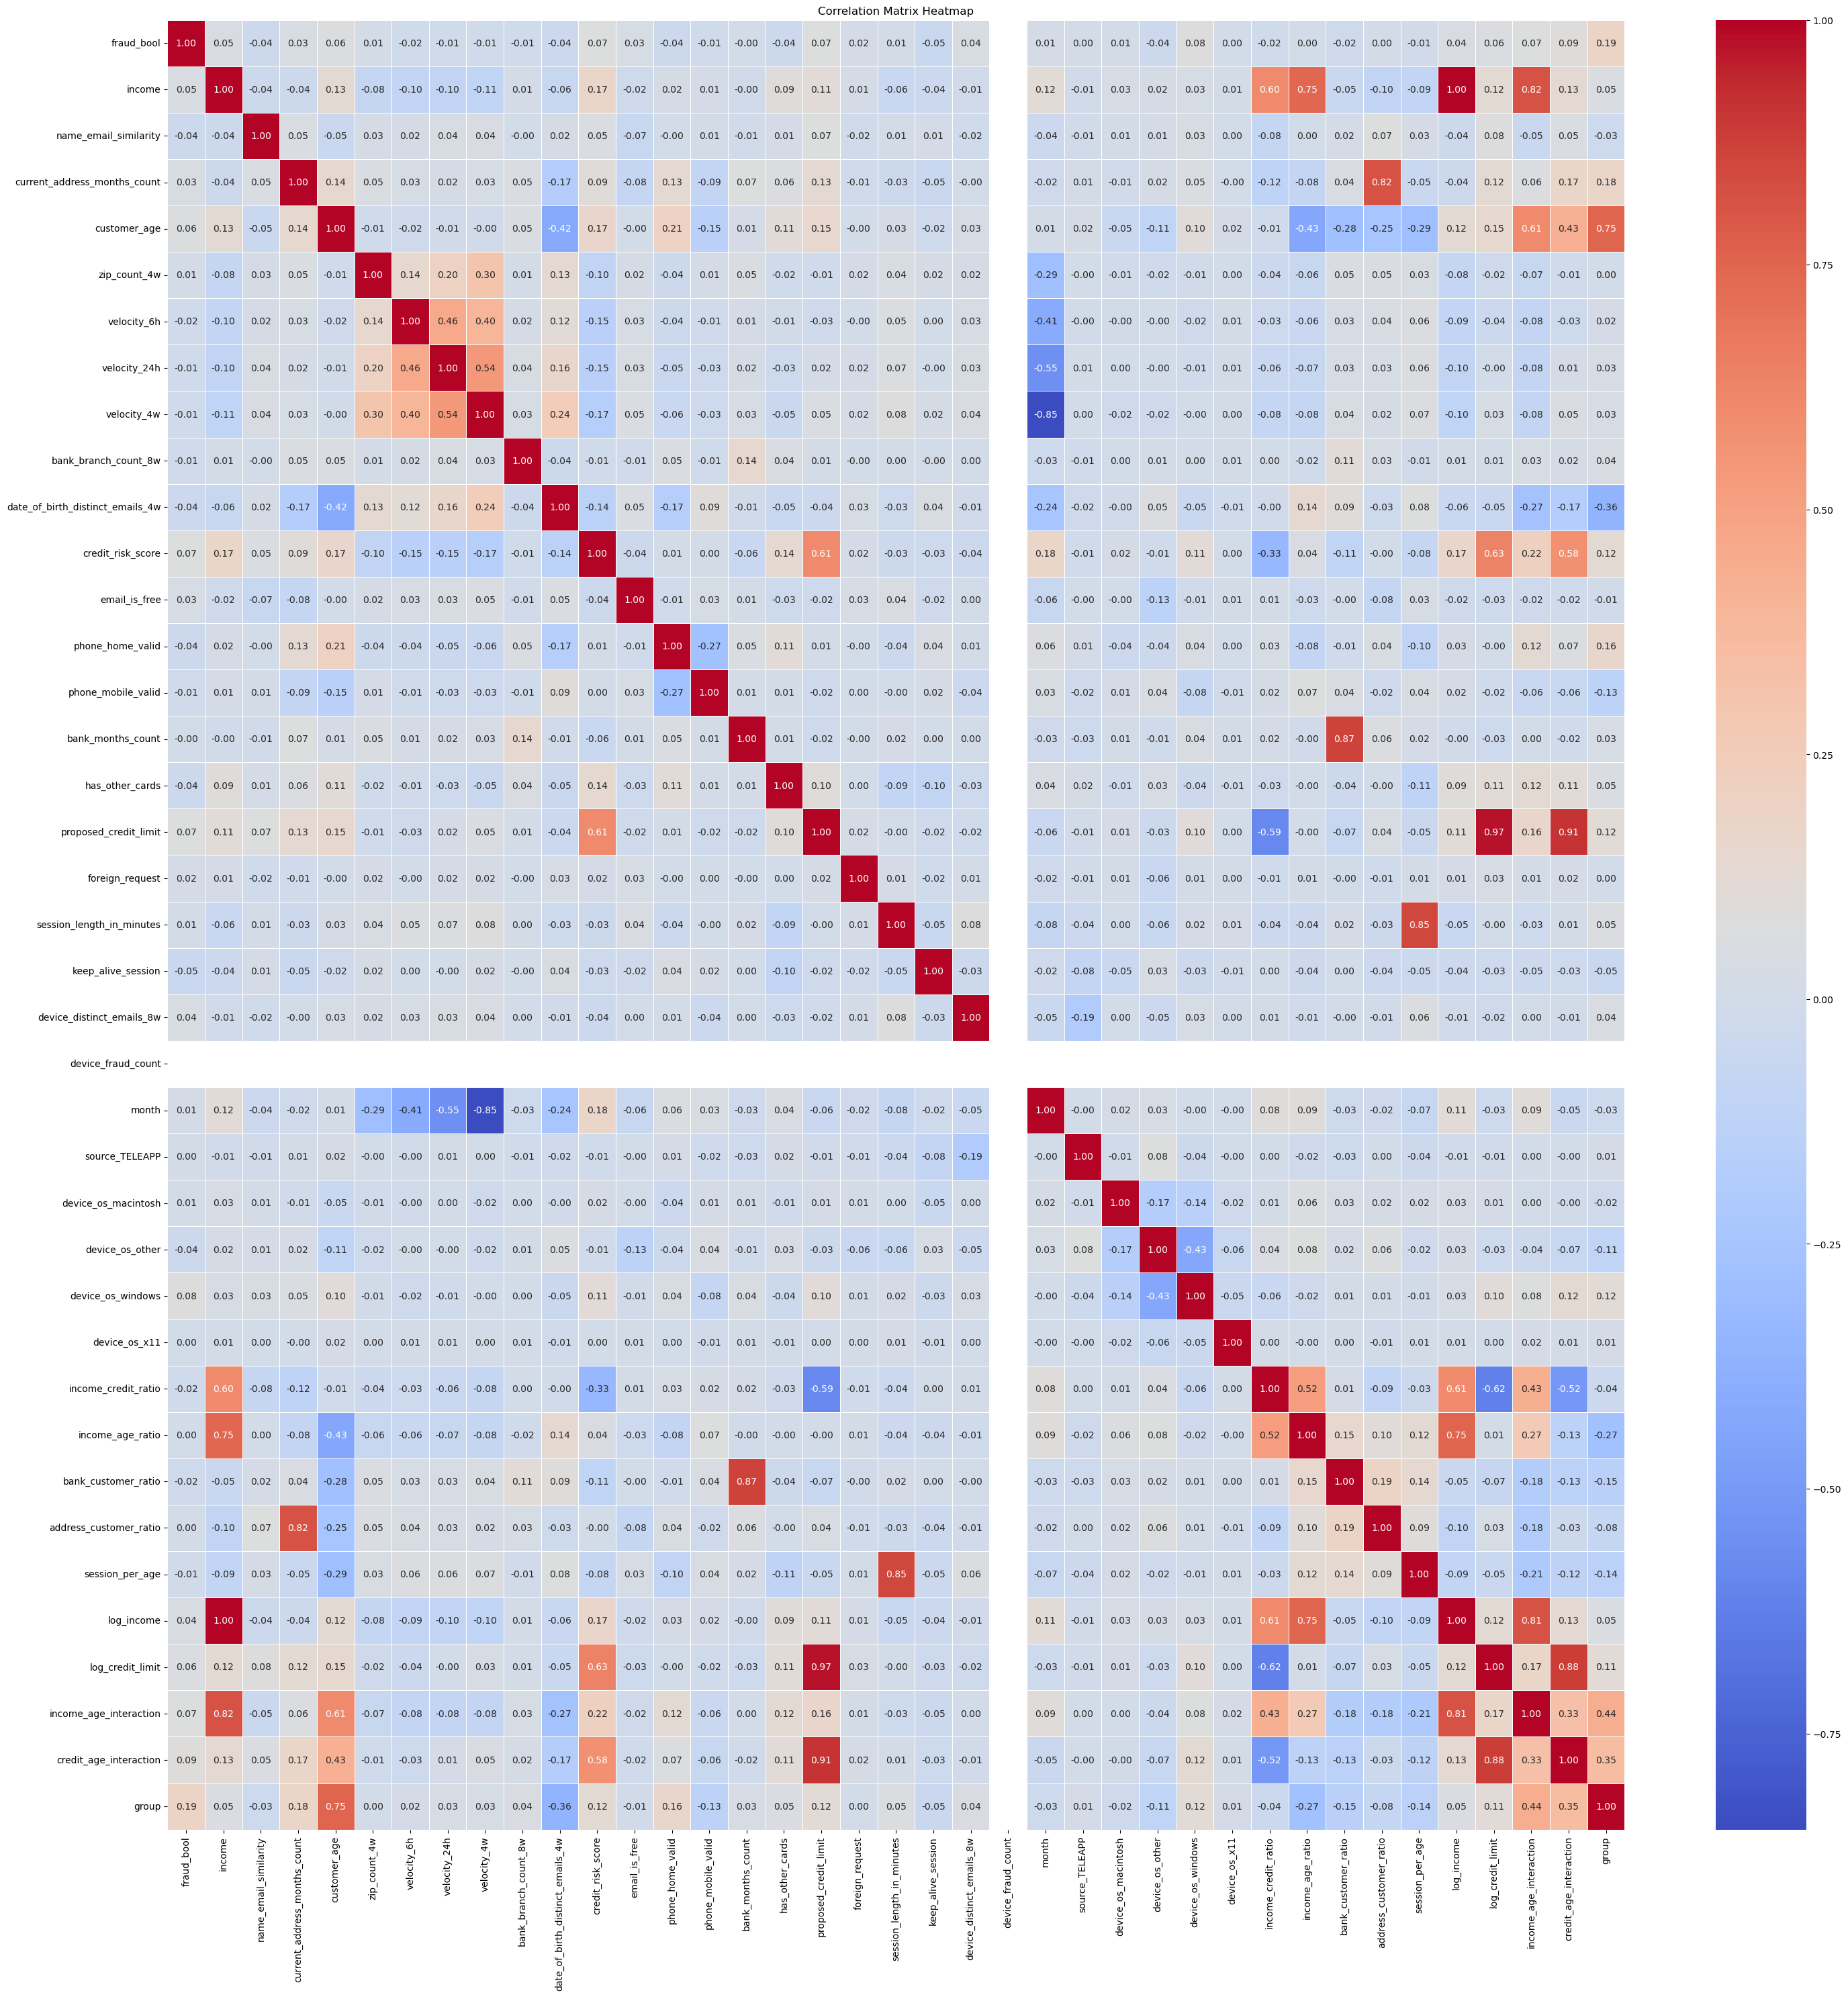

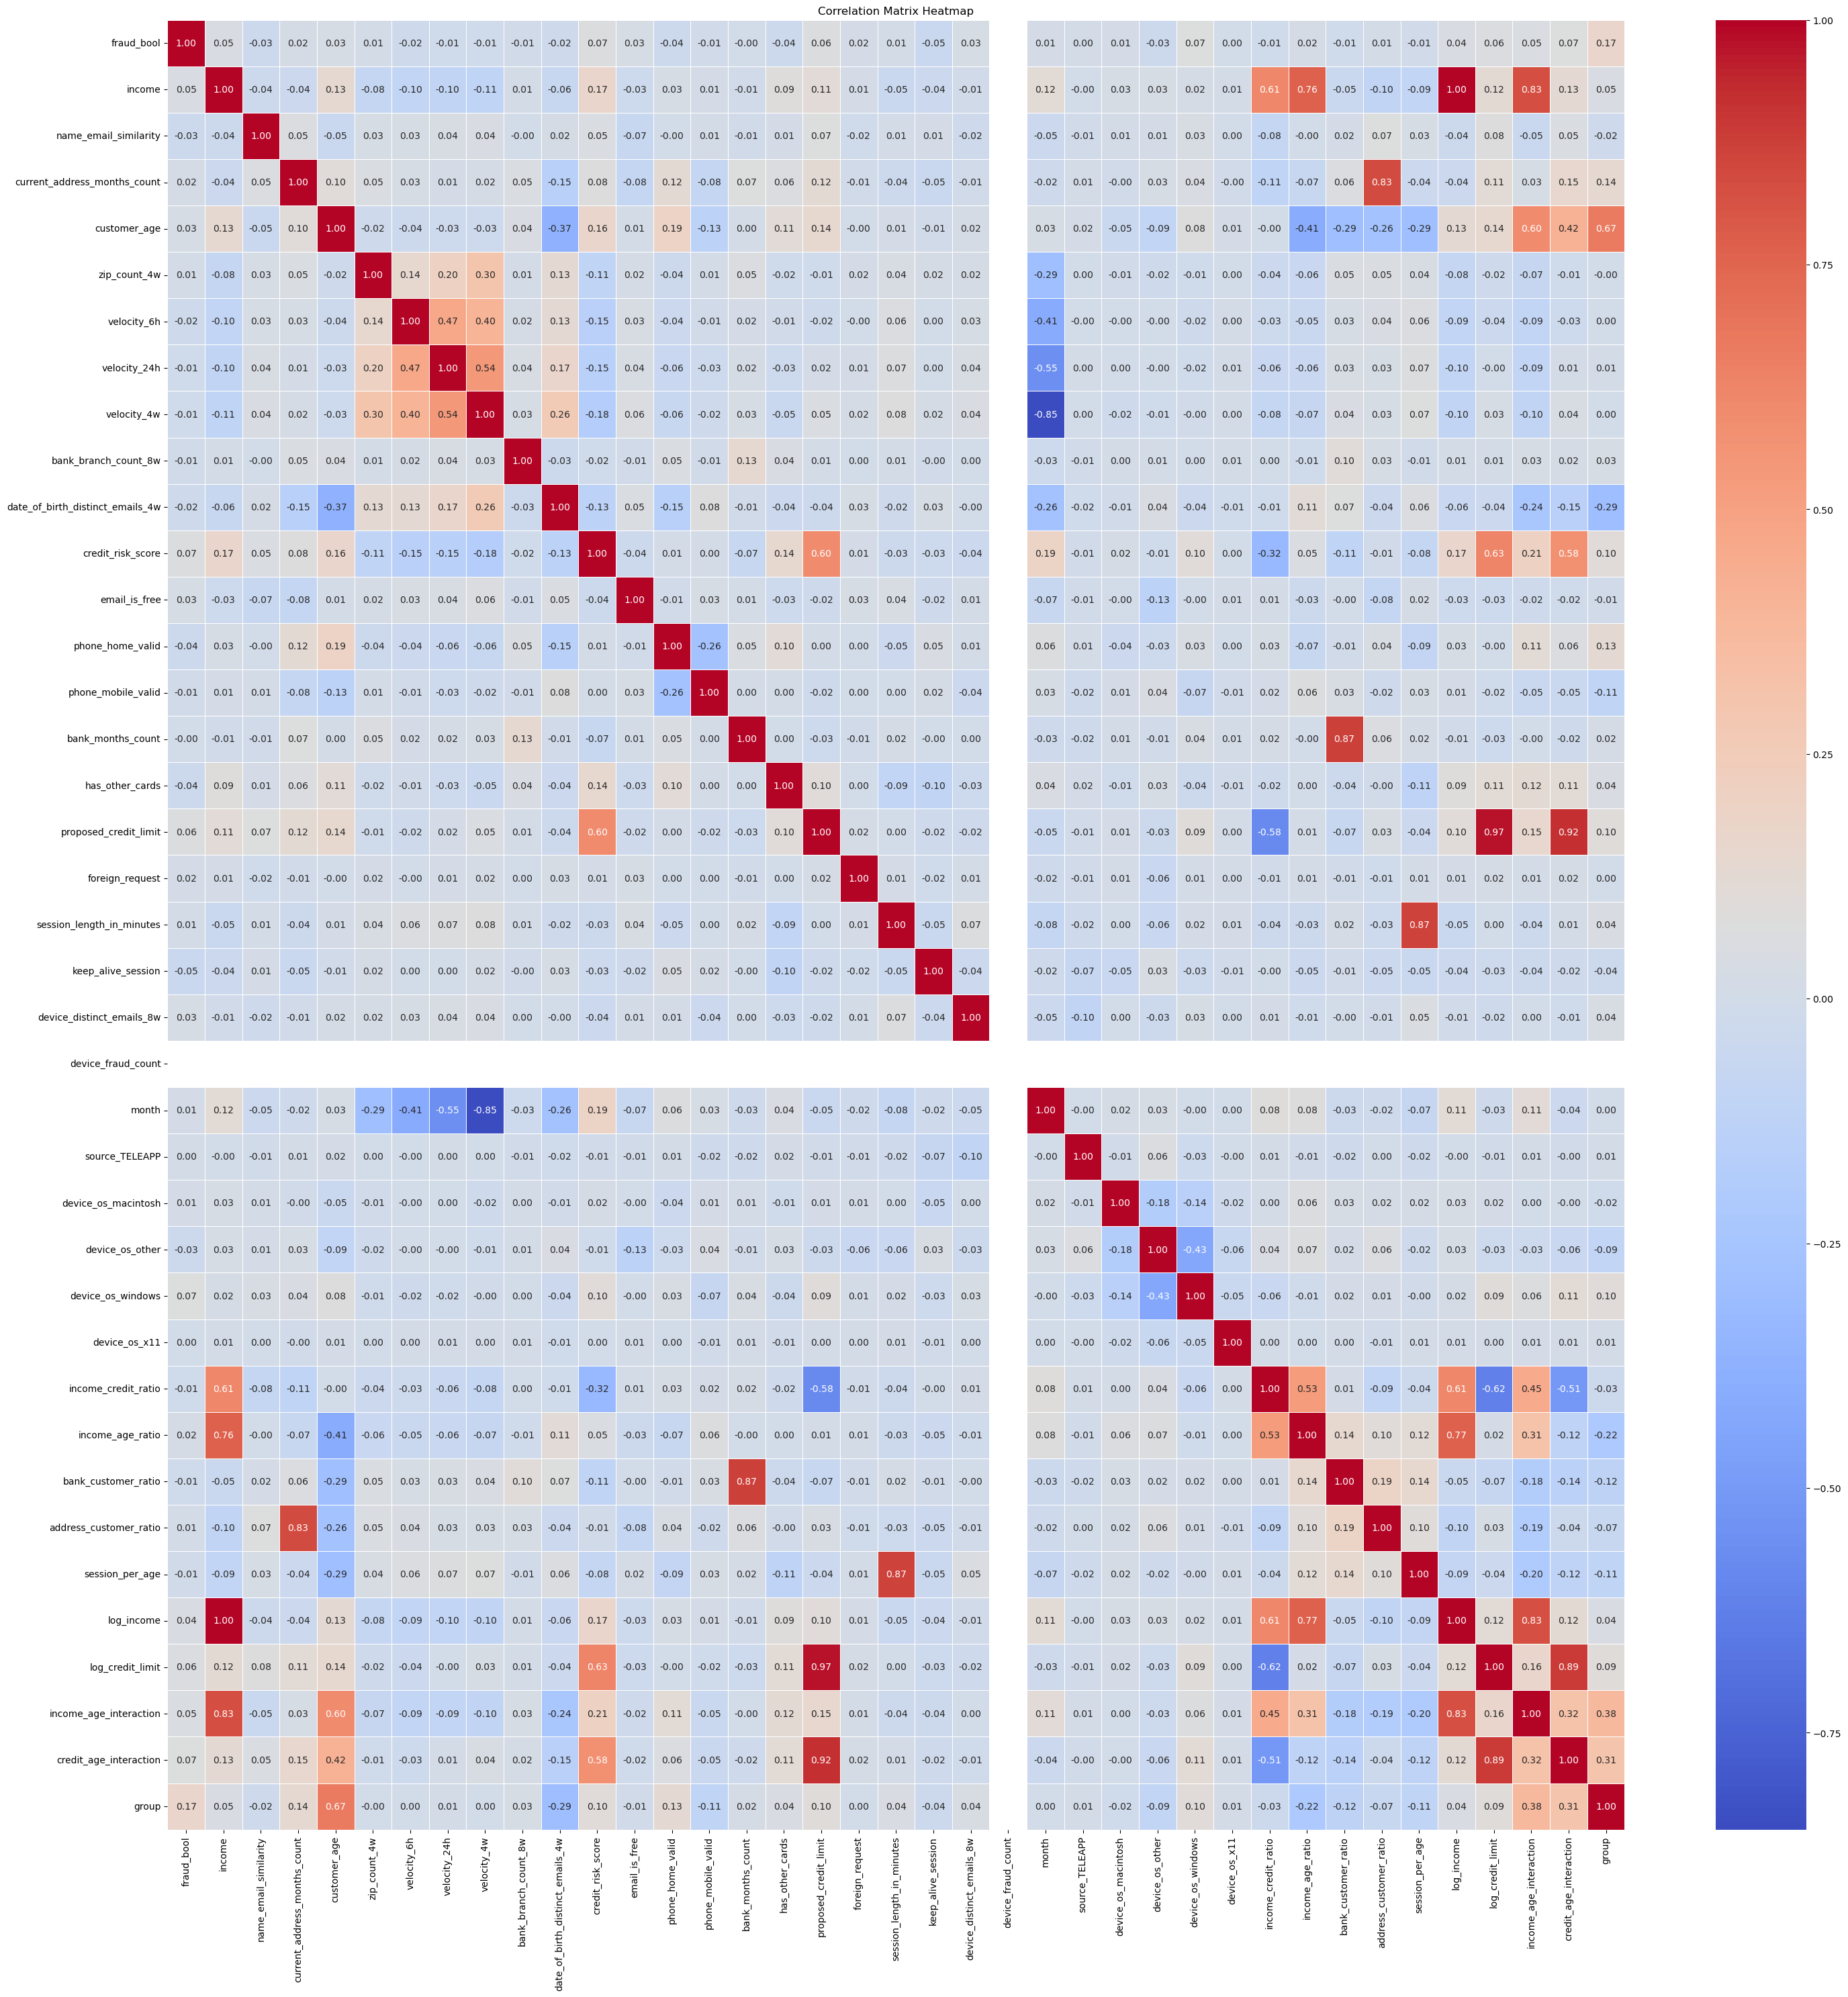

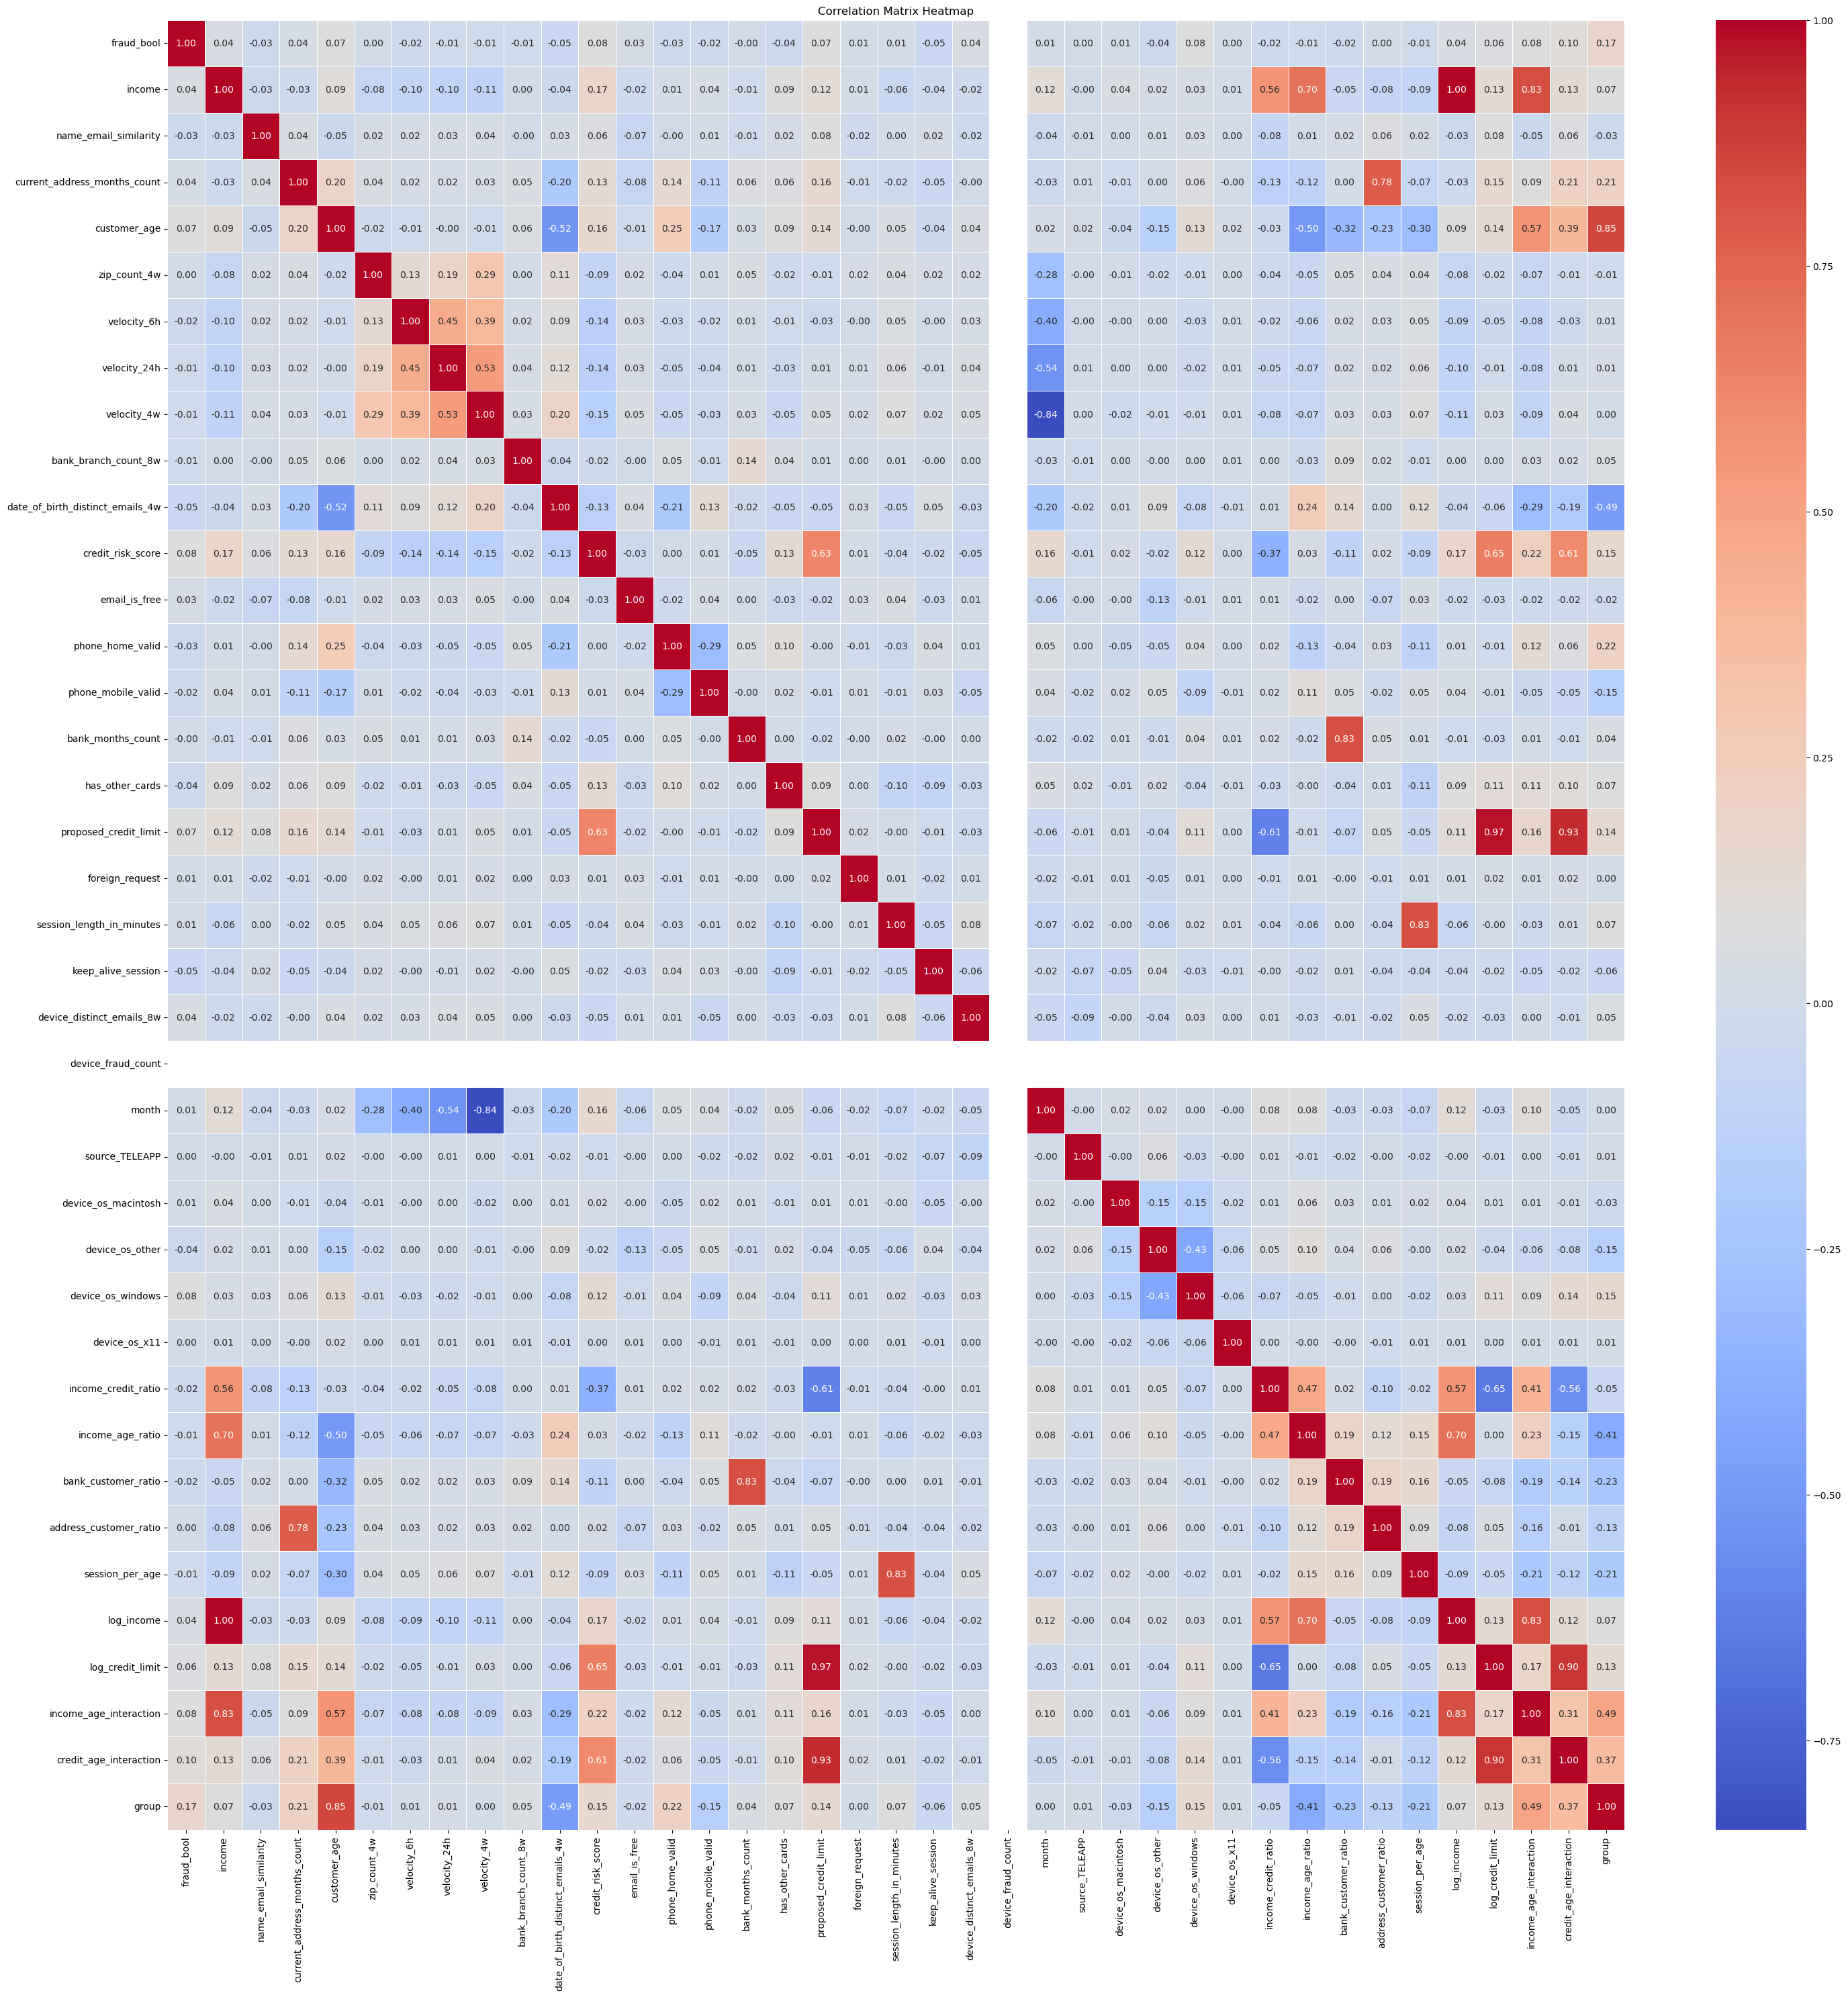

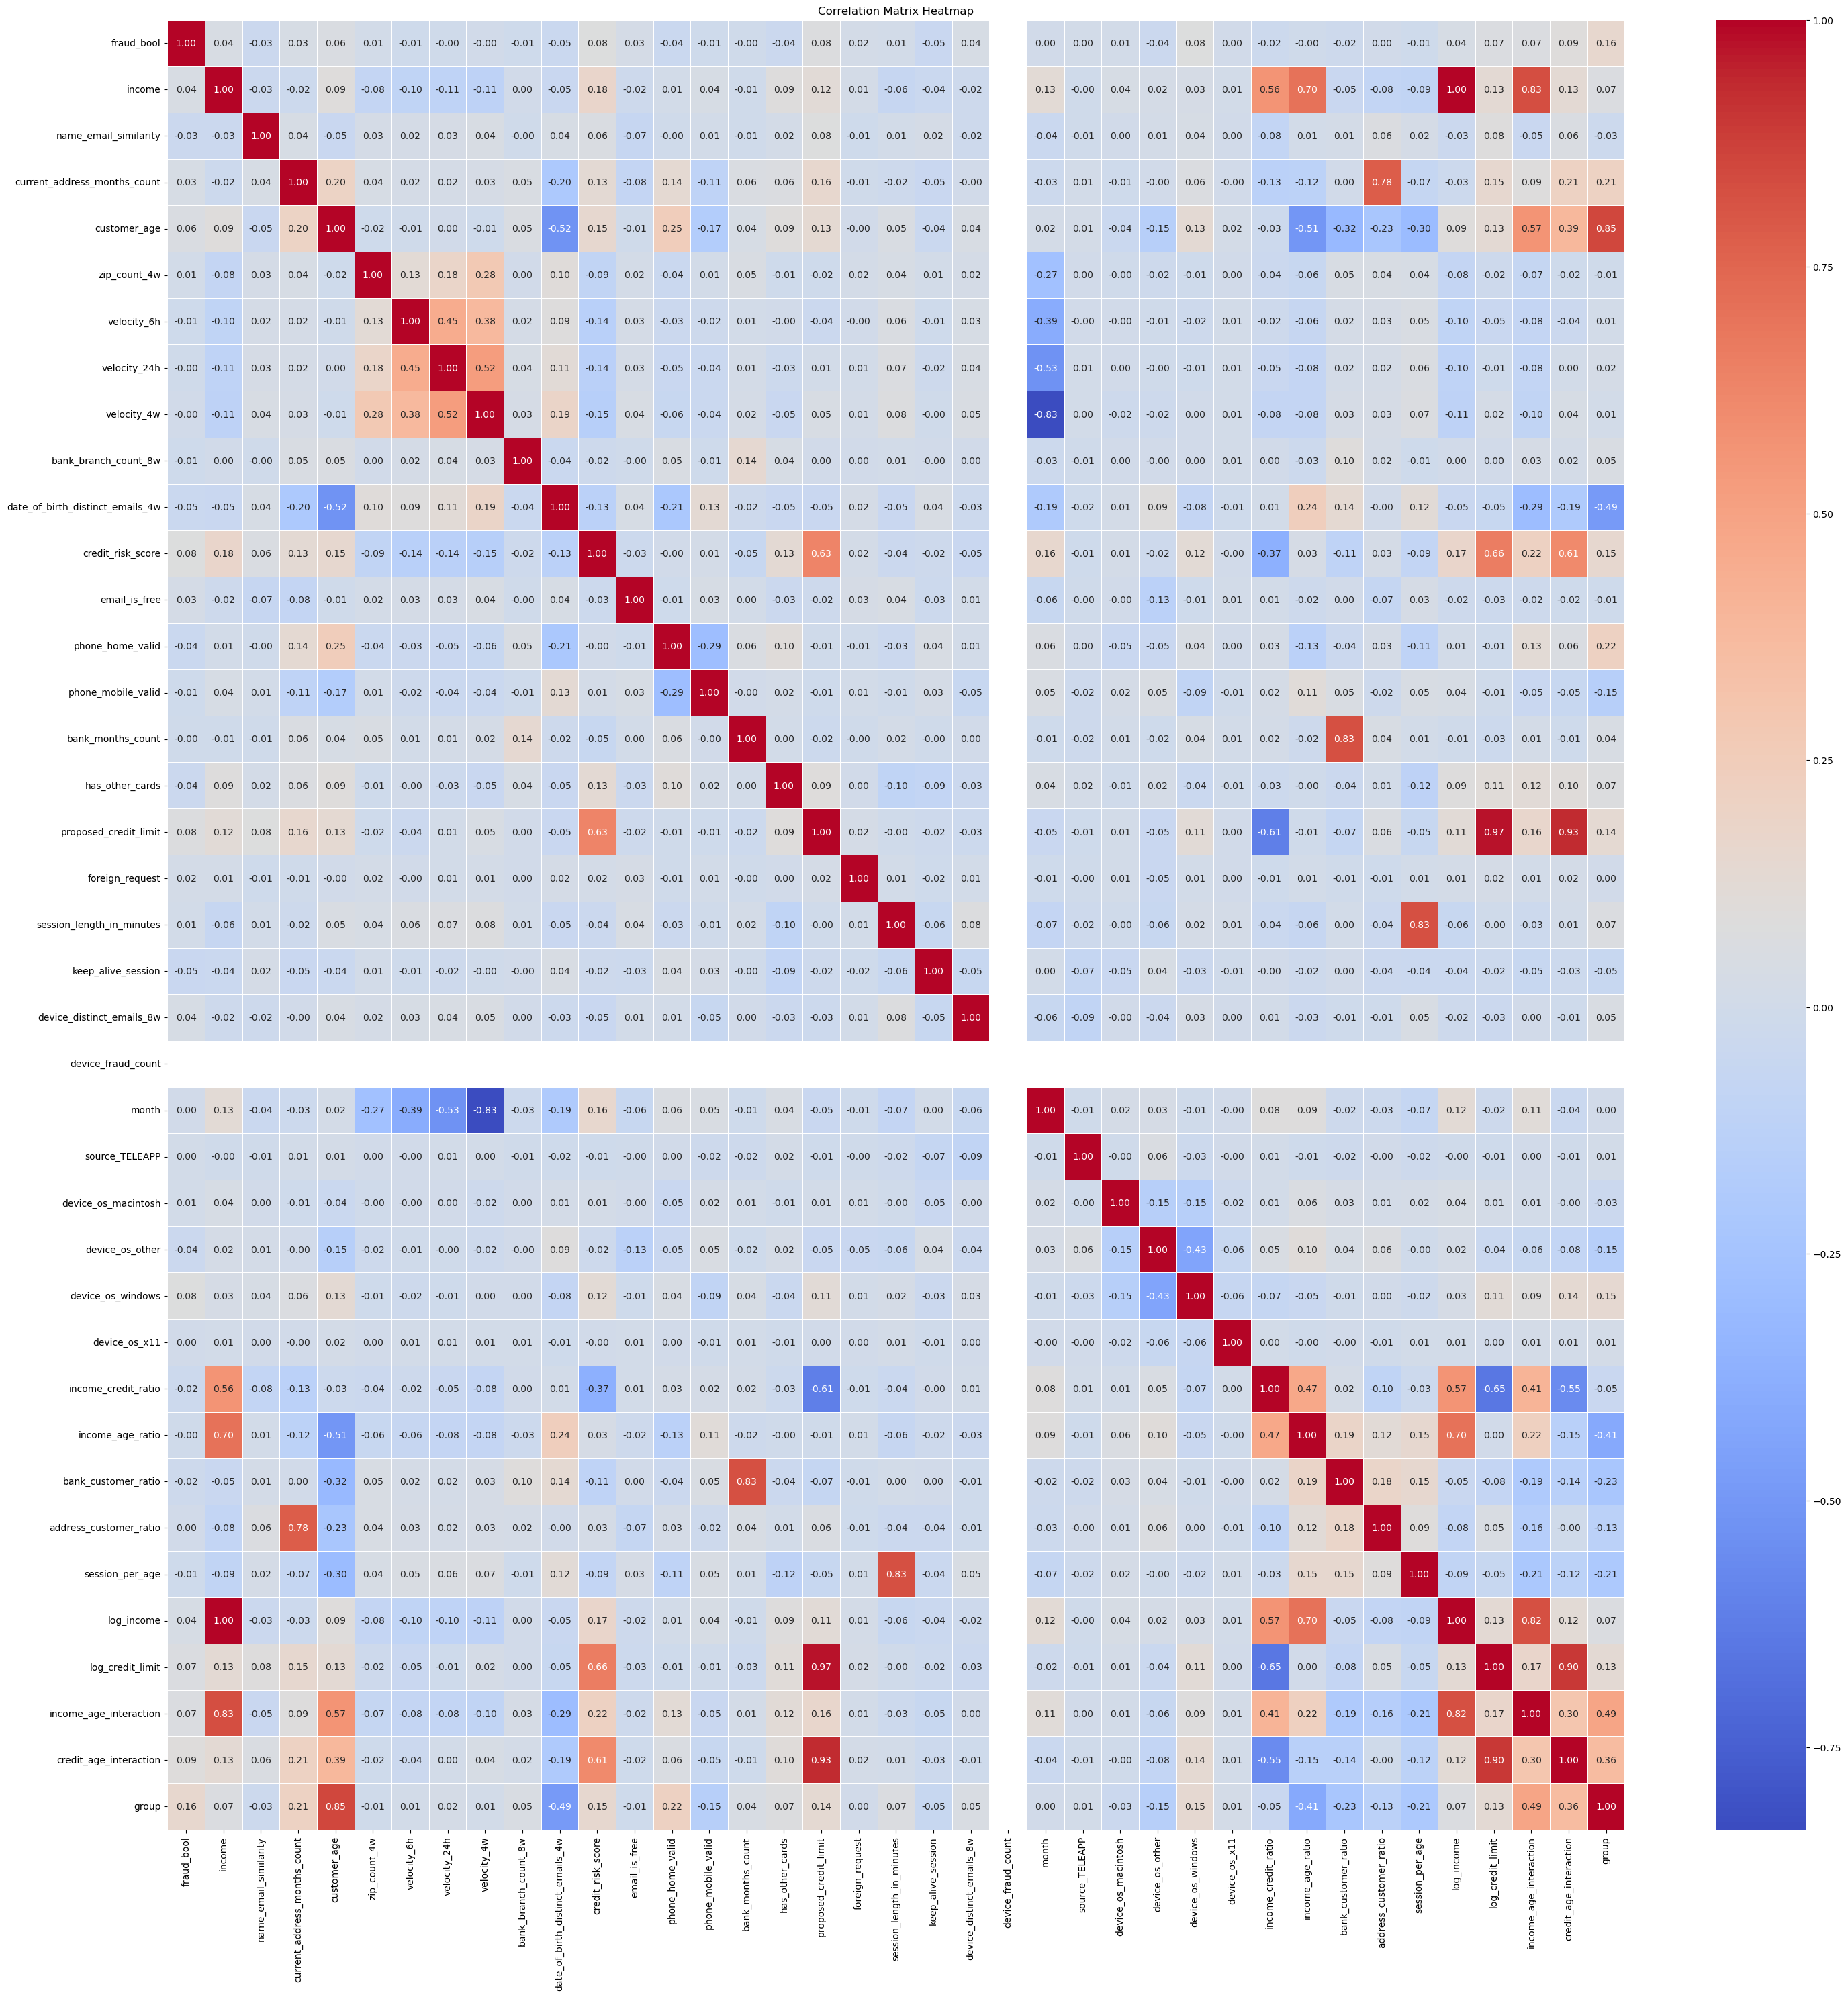

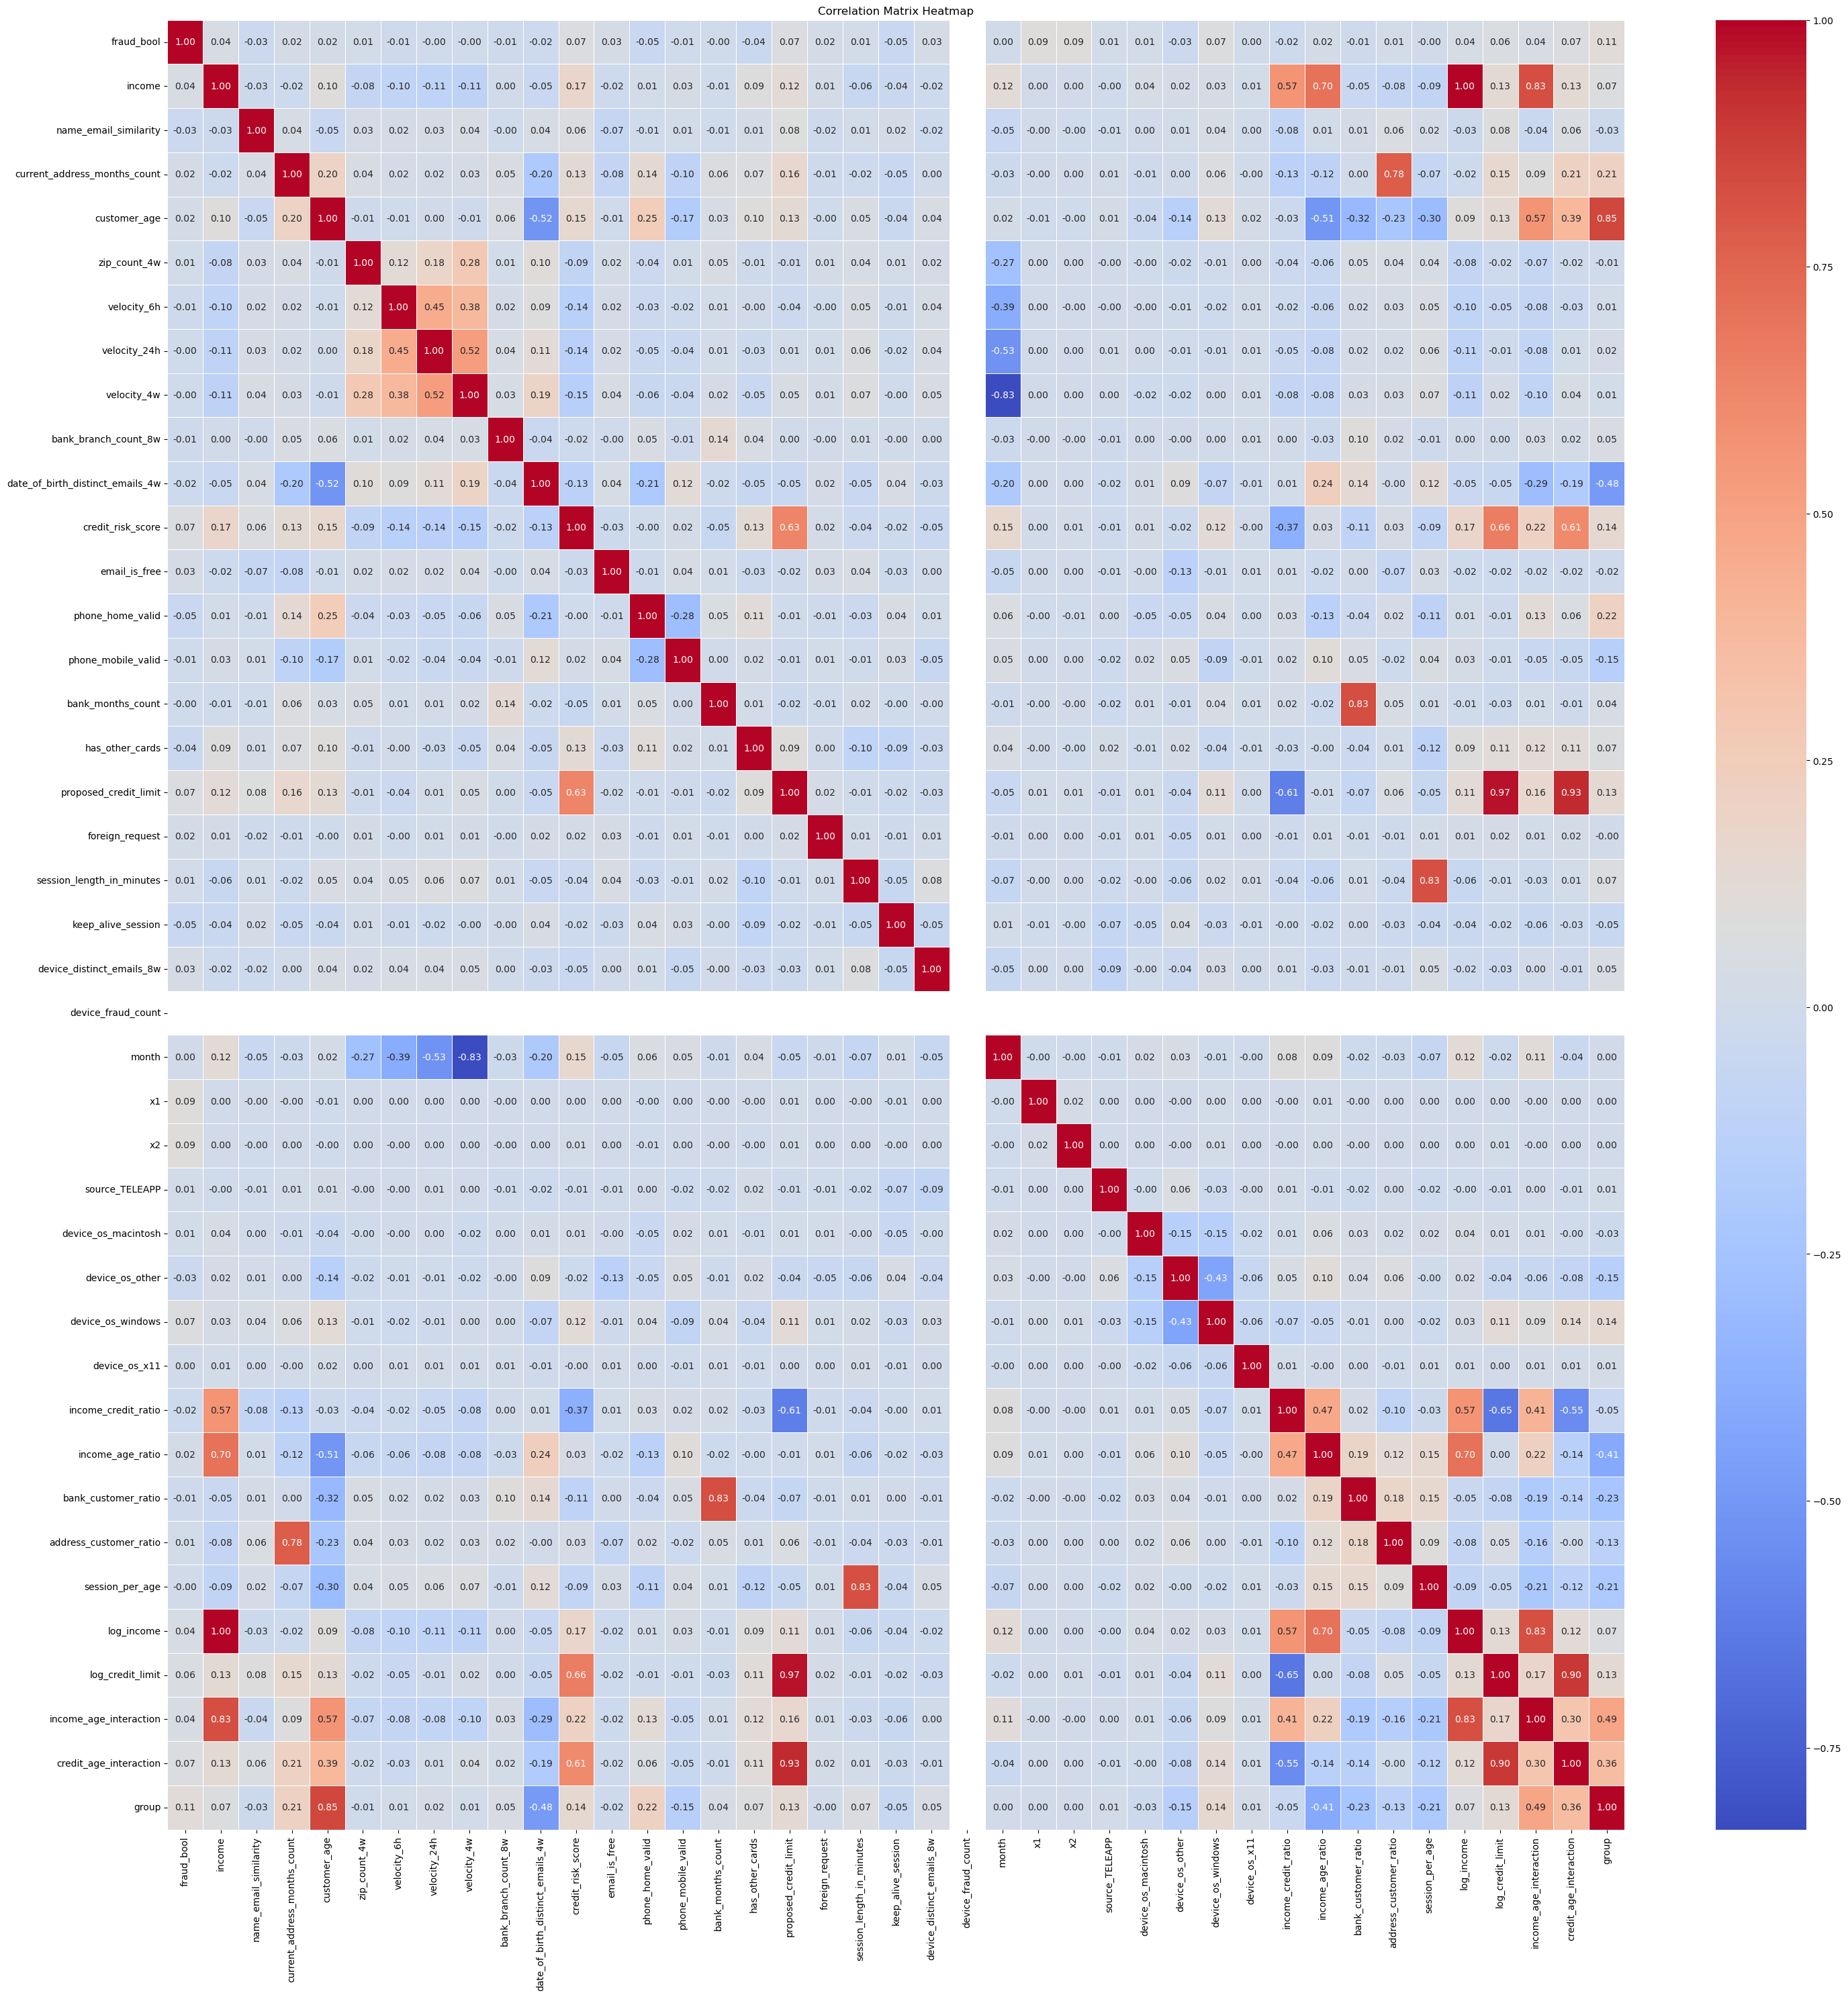

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

df = [base_copy, var1_copy, var2_copy, var3_copy, var4_copy, var5_copy]
for df in df:
    correlation_matrix = df.corr(numeric_only=True)
    plt.figure(figsize=(35, 35))
    sns.heatmap(
        correlation_matrix,  
        annot=True,          
        cmap='coolwarm',     
        fmt=".2f",          
        linewidths=.5,      
        cbar=True           
    )
    plt.title('Correlation Matrix Heatmap')
    plt.show()


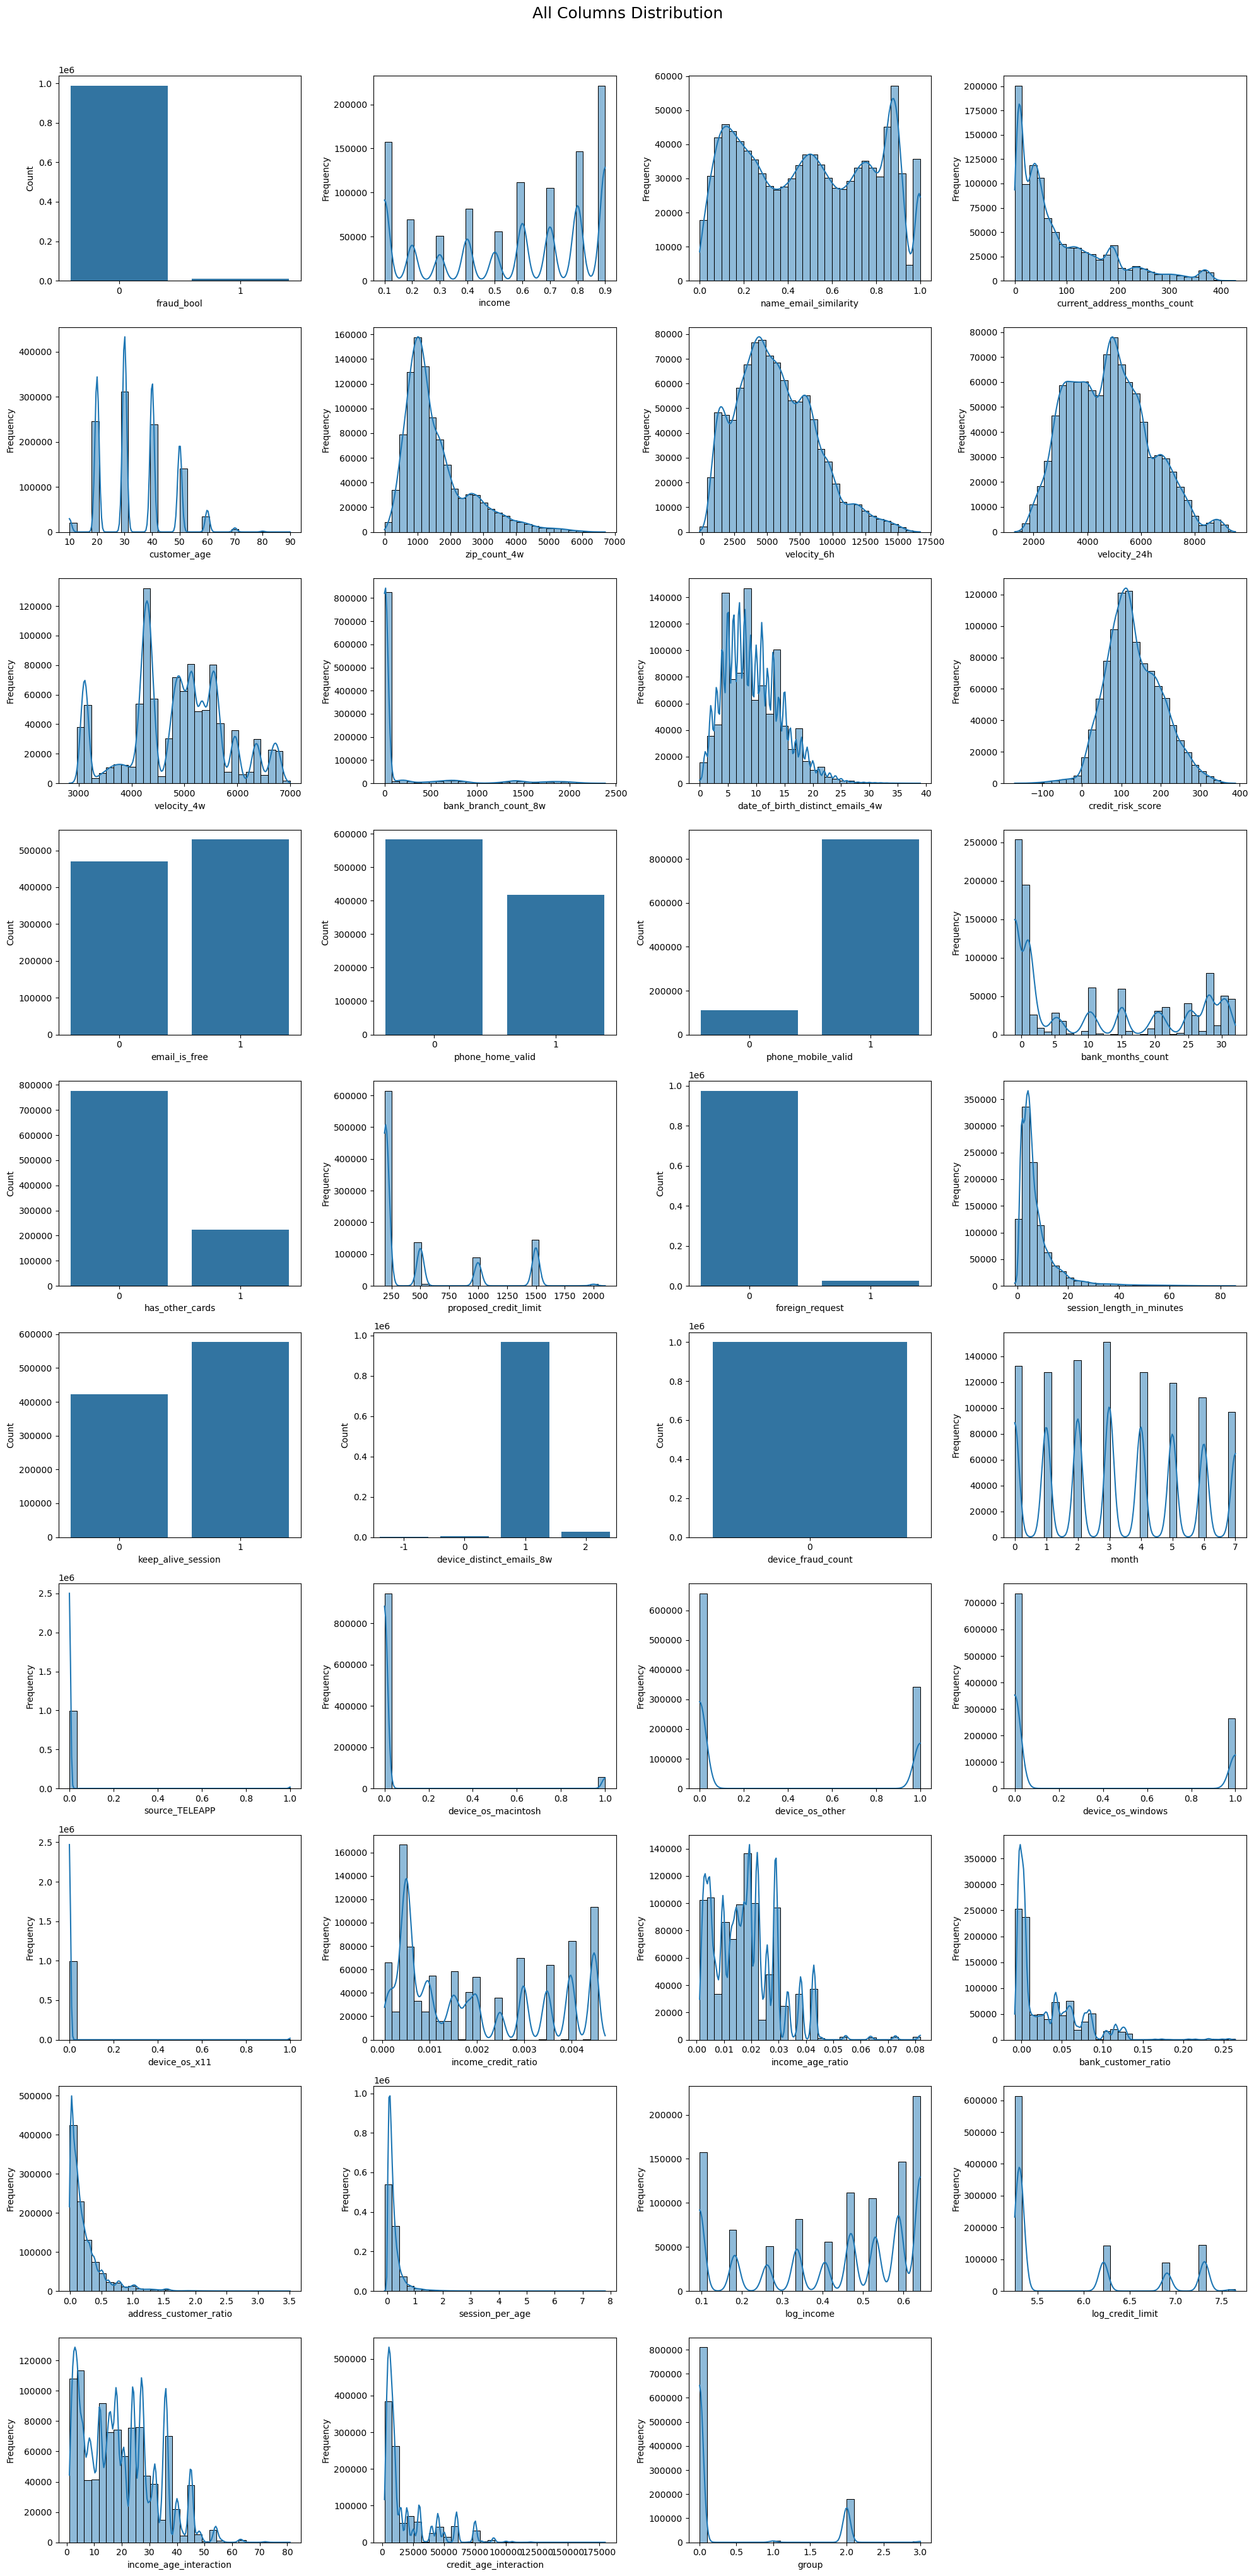

In [62]:
### Distribution of All Columns ###
import matplotlib.pyplot as plt
import seaborn as sns
num_cols = len(base_copy.columns)
x = 4
y = (num_cols + x - 1) // x 
plt.figure(figsize=(x * 5, y * 4))
for i, col in enumerate(base_copy.columns):
    plt.subplot(y, x, i + 1)

    if base_copy[col].nunique() < 5 and base_copy[col].dtype == 'int64':
            sns.countplot(x=col, data=base_copy)
            plt.xlabel(col, fontsize=10)
            plt.ylabel('Count', fontsize=10)

    else:
        sns.histplot(base_copy[col], kde=True, bins=30)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.suptitle('All Columns Distribution', y=1.02, fontsize=18) 
plt.show()

In [63]:
def split_train_test(df):
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 0), 'group'] = 0
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 1), 'group'] = 1
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 0), 'group'] = 2
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 1), 'group'] = 3
    df['group'] = df['group'].astype(int)
    X = df.drop(columns=['fraud_bool', 'group'])
    y = df['fraud_bool']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['group'])
    
    return X_train, X_test, y_train, y_test

In [64]:
x_train_base, x_test_base, y_train_base, y_test_base = split_train_test(base_sam)
x_train_var1, x_test_var1, y_train_var1, y_test_var1 = split_train_test(var1_sam)
x_train_var2, x_test_var2, y_train_var2, y_test_var2 = split_train_test(var2_sam)
x_train_var3, x_test_var3, y_train_var3, y_test_var3 = split_train_test(var3_sam)
x_train_var4, x_test_var4, y_train_var4, y_test_var4 = split_train_test(var4_sam)
x_train_var5, x_test_var5, y_train_var5, y_test_var5 = split_train_test(var5_sam)

In [65]:
XGB = XGBClassifier()

In [66]:
def k_fold_training_smote(model_instance, X_train, y_train):
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for fold, (train_index, val_index) in enumerate(k_fold.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)), # SMOTE 인스턴스
            ('classifier', model_instance)      # 모델 인스턴스 (하이퍼파라미터가 적용된)
        ])
        # 모델 학습
        pipeline.fit(X_train_fold, y_train_fold)
        y_val_proba = pipeline.predict_proba(X_val_fold)[:, 1]
        auc_score = roc_auc_score(y_val_fold, y_val_proba)
        auc_scores.append(auc_score)

        # 마지막 폴드의 결과 저장
        if fold == k_fold.get_n_splits() - 1:
            last_fold_y_val = y_val_fold
            last_fold_y_proba = y_val_proba
            last_trained_pipeline = pipeline # 마지막 학습된 파이프라인 저장

    return auc_scores, last_fold_y_val, last_fold_y_proba, last_trained_pipeline

In [67]:
default_xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc' # K-Fold 훈련 시에는 'auc'보다 'logloss'가 더 일반적
)
datasets = {
    'base':  (x_train_base,  x_test_base,  y_train_base,  y_test_base),
    'var1':  (x_train_var1,  x_test_var1,  y_train_var1,  y_test_var1),
    'var2':  (x_train_var2,  x_test_var2,  y_train_var2,  y_test_var2),
    'var3':  (x_train_var3,  x_test_var3,  y_train_var3,  y_test_var3),
    'var4':  (x_train_var4,  x_test_var4,  y_train_var4,  y_test_var4),
    'var5':  (x_train_var5,  x_test_var5,  y_train_var5,  y_test_var5)
}

In [68]:
roc_data = defaultdict(dict)
pr_data = defaultdict(dict)

for name, (X_tr, X_te, y_tr, y_te) in datasets.items():
    print(f"\n==== Processing dataset: {name} ====")
    
    xgb_model = XGBClassifier(
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='auc' # K-Fold 평가를 위해 'auc' 사용
    )
    
    auc_scores_cv, last_fold_y_val, last_fold_y_proba, last_trained_pipeline = k_fold_training_smote(xgb_model, X_tr, y_tr)
    print(f"  K-Fold Cross-Validation AUC scores: {auc_scores_cv}")
    print(f"  Average CV AUC: {np.mean(auc_scores_cv):.4f}")
    print(f"  CV AUC Standard Deviation: {np.std(auc_scores_cv):.4f}")

    # 중요도 추출 
    booster = last_trained_pipeline.named_steps['classifier'].get_booster()
    importance_dict = booster.get_score(importance_type='weight')  # 'gain', 'cover'도 가능

    # 중요도 DataFrame 생성
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values(by='importance', ascending=False)

    print(importance_df)

    # fmap을 XGBoost 내부의 feature 이름(f0, f1, ...) 기준으로 생성
    fmap = {f"f{i}": col for i, col in enumerate(X_tr.columns)}

    # importance_dict의 key를 실제 feature 이름으로 매핑
    importance_df = pd.DataFrame({
        'feature': [fmap.get(feat, feat) for feat in importance_dict.keys()],
        'importance': list(importance_dict.values())
    }).sort_values(by='importance', ascending=False)
    # 중요도 DataFrame을 출력
    print("변환된 중요도 DataFrame:")
    print(importance_df)
    
    y_pred_label = last_trained_pipeline.predict(X_te)
    y_pred_proba = last_trained_pipeline.predict_proba(X_te)[:, 1]

    auc_score   = roc_auc_score(y_te, y_pred_proba)
    conf_mat    = confusion_matrix(y_te, y_pred_label)
    acc = accuracy_score(y_te, y_pred_label)
    prec = precision_score(y_te, y_pred_label)
    rec = recall_score(y_te, y_pred_label)

    print(f"  테스트 AUC: {auc_score:.4f}, 정확도: {acc:.4f}, 정밀도: {prec:.4f}, 재현율: {rec:.4f}")
    
    # ROC 곡선 좌표 저장 (루프 내에서는 그리지 않음)
    fpr, tpr, thr = roc_curve(y_te, y_pred_proba)
    roc_data[name]['fpr'] = fpr
    roc_data[name]['tpr'] = tpr
    roc_data[name]['auc'] = auc_score
    roc_data[name]['thresholds'] = thr


    # PR 곡선 좌표 저장
    precision_pr, recall_pr, thresholds_pr = precision_recall_curve(y_te, y_pred_proba)
    pr_auc = auc(recall_pr, precision_pr) # PR AUC 계산

    pr_data[name]['precision'] = precision_pr
    pr_data[name]['recall'] = recall_pr
    pr_data[name]['auc'] = pr_auc # PR AUC 저장

    # 최적의 임계값 찾기 (예시: Youden's J statistic 최대화)
    # 'thresholds' 배열은 fpr과 tpr이 계산된 임계값들을 포함합니다.
    # thresholds[0]은 실제 사용된 가장 높은 임계값이며, thresholds[-1]은 가장 낮은 임계값입니다.
    # 일반적으로 thresholds 배열은 내림차순으로 정렬되어 있습니다.
    
    youden_j_scores = tpr - fpr
    youden_idx = np.argmax(youden_j_scores)
    threshold_youden = thr[youden_idx]
    fpr_youden = fpr[youden_idx]
    tpr_youden = tpr[youden_idx]
    print("\nClassification Report with Optimal Threshold (Youden's J):")
    print(f"최적 임계값 (Youden's J): {threshold_youden:.4f}")

    # 선택된 임계값으로 예측 수행
    y_pred_custom_threshold = (y_pred_proba >= threshold_youden).astype(int)
    print(classification_report(y_te, y_pred_custom_threshold))
    
    # 정확도 (Accuracy)
    accuracy = accuracy_score(y_te, y_pred_custom_threshold)

    # 정밀도 (Precision)
    precision = precision_score(y_te, y_pred_custom_threshold, pos_label=1, zero_division=0)

    # 재현율 (Recall)
    recall = recall_score(y_te, y_pred_custom_threshold, pos_label=1, zero_division=0)
    
    print("\n--- 최적 임계값 적용 시 성능 지표 ---")
    print(f"정확도 (Accuracy): {accuracy:.4f}")
    print(f"정밀도 (Precision): {precision:.4f}")
    print(f"재현율 (Recall): {recall:.4f}")


==== Processing dataset: base ====
  K-Fold Cross-Validation AUC scores: [0.7913766631813586, 0.7506032263994852, 0.8247133597412447, 0.7965973154290527, 0.7535365632021754]
  Average CV AUC: 0.7834
  CV AUC Standard Deviation: 0.0280
                             feature  importance
5                        velocity_6h       296.0
6                       velocity_24h       256.0
4                       zip_count_4w       247.0
10                 credit_risk_score       240.0
7                        velocity_4w       232.0
29               bank_customer_ratio       220.0
2       current_address_months_count       212.0
8               bank_branch_count_8w       194.0
1              name_email_similarity       177.0
14                 bank_months_count       172.0
34            income_age_interaction       151.0
9   date_of_birth_distinct_emails_4w       148.0
0                             income       146.0
27               income_credit_ratio       146.0
30            address_custome

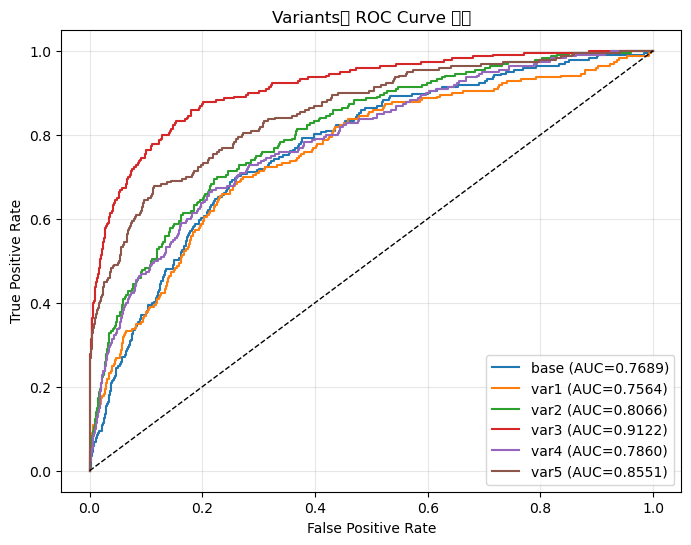

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
plt.figure(figsize=(8, 6))
for name, res in roc_data.items():
    plt.plot(res['fpr'], res['tpr'], label=f"{name} (AUC={res['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Variants별 ROC Curve 비교")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


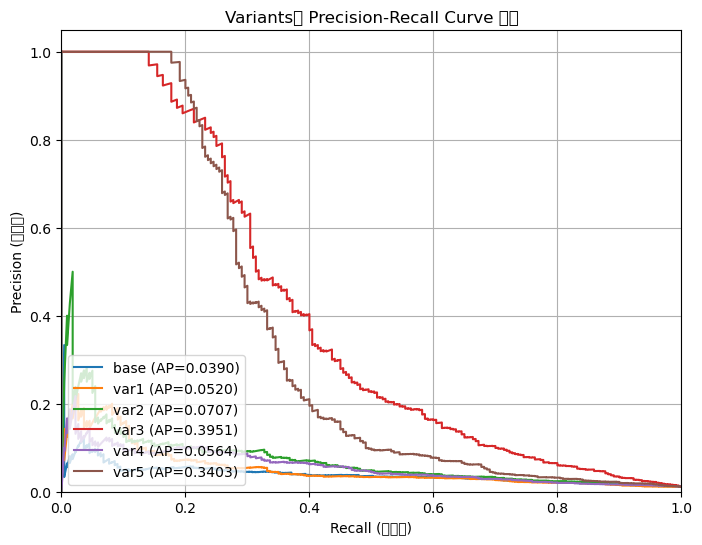

In [70]:
# PR Curve 통합 시각화
plt.figure(figsize=(8, 6))
for name, res in pr_data.items():
    plt.plot(res['recall'], res['precision'], label=f"{name} (AP={res['auc']:.4f})") # AP = Average Precision, PR AUC와 동일

plt.xlabel("Recall (재현율)")
plt.ylabel("Precision (정밀도)")
plt.title("Variants별 Precision-Recall Curve 비교")
plt.legend(loc="lower left")
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()